## Credit: Xuan Lei (Lei.337@osu.edu) 

## This demo provides an implementation of surface coil intensity correction (SCC) for data collected on a Siemens scanner.
### Make sure that you have cloned the [SCC repository](https://github.com/OSU-MR/SCC) from GitHub and are executing brightness_correction_demo_ipynb from the SCC folder.
### Before you run the demo, make sure that the your environment is setup properly. To do that, execute these commands in the terminal. Then, make sure that the SCC environment is selected for this code to run.
* conda create --name SCC python=3.8
* conda activate SCC
* conda install jupyterlab
* conda install ipykernel
* python -m ipykernel install --user --name=SCC


### (1) The following cell will install [Twix Tools](https://github.com/OSU-MR/Python_read_Siemens_rawdata) and then replace twix_map.py with the one modified by Dr. Chong Chen (GitHub ID: MRIOSU)
* Twix Tools are needed to read the raw datafile from Siemens scanners

In [1]:
from helper_functions.download_data import install_twixtools 
install_twixtools() 

please read README.md to run the code.
The code is still under development.
plesae contact me for adding more data shape support.
lei.337@osu.edu


<!-- # 2. Organize the folders of your datasets
# **The sturcture of your dataset folders should be like this:**
<style>
code {
    font-size: 15px;
}
</style>
```markdown


base_dir-----input_folder-----folder name of your datasets_1
          |                |--folder name of your datasets_2
          |                |              ...
          |		        --folder name of your datasets_n
          |
          |
          | (folders below will be automatically created)
          ---output_folder------correction map folder of your datasets_1    
			     |--correction map folder of your datasets_2         
			     |                ...                 
                 ---correction map folder of your datasets_n

``` -->

### (2) This cell will automatically download a raw data file that we have uploaded on [figshare](figshare.com). Be patient, downloading the file may take a few minutes.
* The downloaded file is saved in SCC/data/rawdata/demo folder while the results are saved on SCC/data/results/demo
* The link 'url_2CH' has a series of images from a single slice (620 MB). The link 'url_SAX' has series of images from multiple slices (5.2 GB)

In [2]:
import os
from helper_functions.download_data import download_file_from_figshare
# Path: ./data
#create base directory
os.makedirs('./data', exist_ok=True)

#create subdirectories
os.makedirs('./data/rawdata', exist_ok=True)
os.makedirs('./data/rawdata/demo', exist_ok=True)

#download data
saving_path = './data/rawdata/demo/'
url_2CH = "https://figshare.com/ndownloader/files/41881158" # image collected in two-chambers view
url_SAX = "https://figshare.com/ndownloader/files/41915115" # image stack collected in short-axis view

print("Demo dataset(s) are being downloaded, please wait......")
download_file_from_figshare(saving_path, url_2CH) # May take a couple of minutes to download
#download_file_from_figshare(saving_path,url_SAX) # May take tens of minutes to download


Demo dataset(s) are being downloaded, please wait......


In [3]:

base_dir = "./data"
input_folder = "rawdata"
subfolder = ['demo'] #set this to None, if you want to go through all the subfolders inside input_folder
output_folder = "results"

<!-- # 3. Import the functions and define the folders -->

### (3) Importing functions and setting the input/output path.

In [4]:
import numpy as np

# from helper_functions.brightness_correction import , getting_and_saving_correction_map, create_and_start_threadings, 
from helper_functions.brightness_correction import target_path_generator, displaying_results, rawdata_reader, correction_map_generator, auto_image_rotation, data_reduction, save_sense_recon_results
from helper_functions.recon import sense_reconstruction, remove_edges, rotate_image, pad_ref
from helper_functions.preprocess import ifftnd, rms_comb,remove_RO_oversamling, compress_data_with_pca

path_input, path_output,  = target_path_generator(base_dir, input_folder, output_folder, subfolder)

### (4) Option 1: Applying the SCC method to correct reconstruced images
#### img_correction_map is used to correct reconstructed images by element-wise multiplying img_correction_map with the reconstructed coil-combined image

In [5]:
from helper_functions.preprocess import ifftnd, rms_comb,remove_RO_oversamling, compress_data_with_pca

In [6]:
auto_rotation = 'LGE' # 'Dicom' or 'LGE'
apply_correction_to_sensitivity_maps = False # True or False
channel_keep = 8 # number of channels to keep after coil compression if you don't want to do coil compression then set this to None
lamb = 5e-2      # regularization parameter for generating the correction maps, the larger the value the smoother the maps

for i, data_path_filename in enumerate(path_input):
    
    twix, image_3D_body_coils, image_3D_surface_coils, data, dim_info_data, data_ref, dim_info_ref, num_sli = rawdata_reader(data_path_filename)

    #coil compression with PCA, you can use the u parameter to preform the same coil compression on extra data
    data, data_ref, image_3D_surface_coils, u = compress_data_with_pca(data = data, channel_keep = channel_keep, axis_CH= dim_info_data.index('Cha'), 
                             extra_data=data_ref, extra_axis_CH=dim_info_ref.index('Cha'), 
                             extra_data2=image_3D_surface_coils, extra_axis_CH2=-1)

    #coil compression end

    img_correction_map, sens_correction_map, low_resolution_surface_coil_imgs, img_quats = correction_map_generator(twix, 
                                                                                                                    image_3D_body_coils, image_3D_surface_coils, 
                                                                                                                    data, dim_info_data, num_sli , 
                                                                                                                    auto_rotation = auto_rotation, 
                                                                                                                    lamb = lamb, tol = 1e-4, maxiter=500,
                                                                                                                    apply_correction_to_sensitivity_maps = apply_correction_to_sensitivity_maps)

    #define sense recon results
    sense_recon_results = np.zeros((num_sli,data.shape[dim_info_data.index('Lin')],data.shape[dim_info_data.index('Col')]//2),dtype=np.complex64)
    
    #only do recon one image for each different slices (this is for demo purpose)
    data,dim_info_data = data_reduction(data,data_dimensions = dim_info_data, dims_to_keep = ['Sli', 'Lin', 'Cha', 'Col'])

    for n in range(num_sli):
        #preprocessing for the sense reconstruction
        ksp,ref_padded = pad_ref(data,data_ref,n,dim_info_ref = dim_info_ref,dim_info_org=dim_info_data)
        ksp = remove_RO_oversamling(ksp,axis_RO=dim_info_data.index('Col'))
        ref_padded = remove_RO_oversamling(ref_padded,axis_RO=dim_info_ref.index('Col'))

        if apply_correction_to_sensitivity_maps:
            #if we want to apply the correction during the sense reconstruction
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded,sens_correction_map[n,...])
        else:
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded)

        sense_recon_results[n,...] = sense_reconstructed_img


    #we are rotating the images here (pptional, may not apply to other datasets)
    sense_recon_results, img_correction_map, sens_correction_map = auto_image_rotation(sense_recon_results, img_quats, 
                                                                            auto_rotation = auto_rotation, 
                                                                            img_correction_map = img_correction_map, 
                                                                            sens_correction_map = sens_correction_map,
                                                                            filename = data_path_filename)
    
    #save the results
    save_sense_recon_results(path_output[i],sense_recon_results, img_correction_map, sens_correction_map, img_quats, apply_correction_to_sensitivity_maps)


Software version: VD/VE (!?)

Scan  0


100%|██████████| 56.2M/56.2M [00:00<00:00, 372MB/s]


Scan  1


100%|██████████| 535M/535M [00:00<00:00, 1.57GB/s]



number of separate scans (multi-raid): 2
original data shape: (2, 32, 32, 30, 128)
['Set', 'Par', 'Lin', 'Cha', 'Col']
(2, 32, 32, 30, 128)
1 1
arranged data shape (128, 32, 32, 30, 2, 1, 1)
['RO', 'E1', 'E2', 'Cha', 'Set', 'S', 'Sli']
3d image shape: (128, 32, 32, 30, 2)
num_sli in the rawdata 1
compress  30  to  8  channels
compress  30  to  8  channels
compress  30  to  8  channels
The 3D reference matrix has been extended to (128, 64, 64)
The 3D reference matrix has been extended to (128, 64, 64)
CG converged after 335 iterations.
Time to apply correction is: 8.330 s
0 16 16
The 3D reference matrix has been cropped to (128, 32, 32)
Dimension 'Sli' not found, skipping.


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Software version: VD/VE (!?)

Scan  0


100%|██████████| 56.2M/56.2M [00:00<00:00, 718MB/s]


Scan  1


100%|██████████| 535M/535M [00:00<00:00, 1.46GB/s]



number of separate scans (multi-raid): 2
original data shape: (2, 32, 32, 30, 128)
['Set', 'Par', 'Lin', 'Cha', 'Col']
(2, 32, 32, 30, 128)
1 1
arranged data shape (128, 32, 32, 30, 2, 1, 1)
['RO', 'E1', 'E2', 'Cha', 'Set', 'S', 'Sli']
3d image shape: (128, 32, 32, 30, 2)
num_sli in the rawdata 1
compress  30  to  8  channels
compress  30  to  8  channels
compress  30  to  8  channels
The 3D reference matrix has been extended to (128, 64, 64)
The 3D reference matrix has been extended to (128, 64, 64)
CG converged after 348 iterations.
Time to apply correction is: 8.526 s
0 16 16
The 3D reference matrix has been cropped to (128, 32, 32)
Dimension 'Sli' not found, skipping.


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

### (5) Option 2: Applying the SCC method to correct sensitivity maps
#### senitivity_correction_maps is used to correct ESPIRiT maps by element-wise multiplying ESPIRiT maps with a with sensivity_correction_map. 

In [11]:
auto_rotation = 'LGE' # 'Dicom' or 'LGE'
apply_correction_to_sensitivity_maps = True # True or False
channel_keep = 8 # number of channels to keep after coil compression if you don't want to do coil compression then set this to None
#lamb = 1e-2      # regularization parameter for generating the correction maps, the larger the value the smoother the maps

for i, data_path_filename in enumerate(path_input):
    
    twix, image_3D_body_coils, image_3D_surface_coils, data, dim_info_data, data_ref, dim_info_ref, num_sli = rawdata_reader(data_path_filename)

    #coil compression with PCA, you can use the u parameter to preform the same coil compression on extra data
    data, data_ref, image_3D_surface_coils, u = compress_data_with_pca(data = data, channel_keep = channel_keep, axis_CH= dim_info_data.index('Cha'), 
                             extra_data=data_ref, extra_axis_CH=dim_info_ref.index('Cha'), 
                             extra_data2=image_3D_surface_coils, extra_axis_CH2=-1)

    #coil compression end

    img_correction_map, sens_correction_map, low_resolution_surface_coil_imgs, img_quats = correction_map_generator(twix, 
                                                                                                                    image_3D_body_coils, image_3D_surface_coils, 
                                                                                                                    data, dim_info_data, num_sli , 
                                                                                                                    auto_rotation = auto_rotation, 
                                                                                                                    lamb = lamb, tol = 1e-4, maxiter=500,
                                                                                                                    apply_correction_to_sensitivity_maps = apply_correction_to_sensitivity_maps)

    #define sense recon results
    sense_recon_results = np.zeros((num_sli,data.shape[dim_info_data.index('Lin')],data.shape[dim_info_data.index('Col')]//2),dtype=np.complex64)
    
    #only do recon one image for each different slices (this is for demo purpose)
    data,dim_info_data = data_reduction(data,data_dimensions = dim_info_data, dims_to_keep = ['Sli', 'Lin', 'Cha', 'Col'])

    for n in range(num_sli):
        #preprocessing for the sense reconstruction
        ksp,ref_padded = pad_ref(data,data_ref,n,dim_info_ref = dim_info_ref,dim_info_org=dim_info_data)
        ksp = remove_RO_oversamling(ksp,axis_RO=dim_info_data.index('Col'))
        ref_padded = remove_RO_oversamling(ref_padded,axis_RO=dim_info_ref.index('Col'))

        if apply_correction_to_sensitivity_maps:
            #if we want to apply the correction during the sense reconstruction
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded,sens_correction_map[n,...])
        else:
            sense_reconstructed_img = sense_reconstruction(ksp,ref_padded)

        sense_recon_results[n,...] = sense_reconstructed_img


    #we are rotating the images here (pptional, may not apply to other datasets)
    sense_recon_results, img_correction_map, sens_correction_map = auto_image_rotation(sense_recon_results, img_quats, 
                                                                            auto_rotation = auto_rotation, 
                                                                            img_correction_map = img_correction_map, 
                                                                            sens_correction_map = sens_correction_map,
                                                                            filename = data_path_filename)
    
    #save the results
    save_sense_recon_results(path_output[i],sense_recon_results, img_correction_map, sens_correction_map, img_quats, apply_correction_to_sensitivity_maps)


Software version: VD/VE (!?)

Scan  0


100%|██████████| 56.2M/56.2M [00:00<00:00, 769MB/s]


Scan  1


100%|██████████| 535M/535M [00:00<00:00, 1.12GB/s] 



number of separate scans (multi-raid): 2
original data shape: (2, 32, 32, 30, 128)
['Set', 'Par', 'Lin', 'Cha', 'Col']
(2, 32, 32, 30, 128)
1 1
arranged data shape (128, 32, 32, 30, 2, 1, 1)
['RO', 'E1', 'E2', 'Cha', 'Set', 'S', 'Sli']
3d image shape: (128, 32, 32, 30, 2)
num_sli in the rawdata 1
compress  30  to  8  channels
compress  30  to  8  channels
compress  30  to  8  channels
The 3D reference matrix has been extended to (128, 64, 64)
The 3D reference matrix has been extended to (128, 64, 64)
CG converged after 426 iterations.
Time to apply correction is: 10.774 s
0 16 16
The 3D reference matrix has been cropped to (128, 32, 32)
Dimension 'Sli' not found, skipping.


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Software version: VD/VE (!?)

Scan  0


100%|██████████| 56.2M/56.2M [00:00<00:00, 749MB/s]


Scan  1


100%|██████████| 535M/535M [00:00<00:00, 1.44GB/s]



number of separate scans (multi-raid): 2
original data shape: (2, 32, 32, 30, 128)
['Set', 'Par', 'Lin', 'Cha', 'Col']
(2, 32, 32, 30, 128)
1 1
arranged data shape (128, 32, 32, 30, 2, 1, 1)
['RO', 'E1', 'E2', 'Cha', 'Set', 'S', 'Sli']
3d image shape: (128, 32, 32, 30, 2)
num_sli in the rawdata 1
compress  30  to  8  channels
compress  30  to  8  channels
compress  30  to  8  channels
The 3D reference matrix has been extended to (128, 64, 64)
The 3D reference matrix has been extended to (128, 64, 64)
CG converged after 419 iterations.
Time to apply correction is: 10.017 s
0 16 16
The 3D reference matrix has been cropped to (128, 32, 32)
Dimension 'Sli' not found, skipping.


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

### (6) Displaying results from an example slice

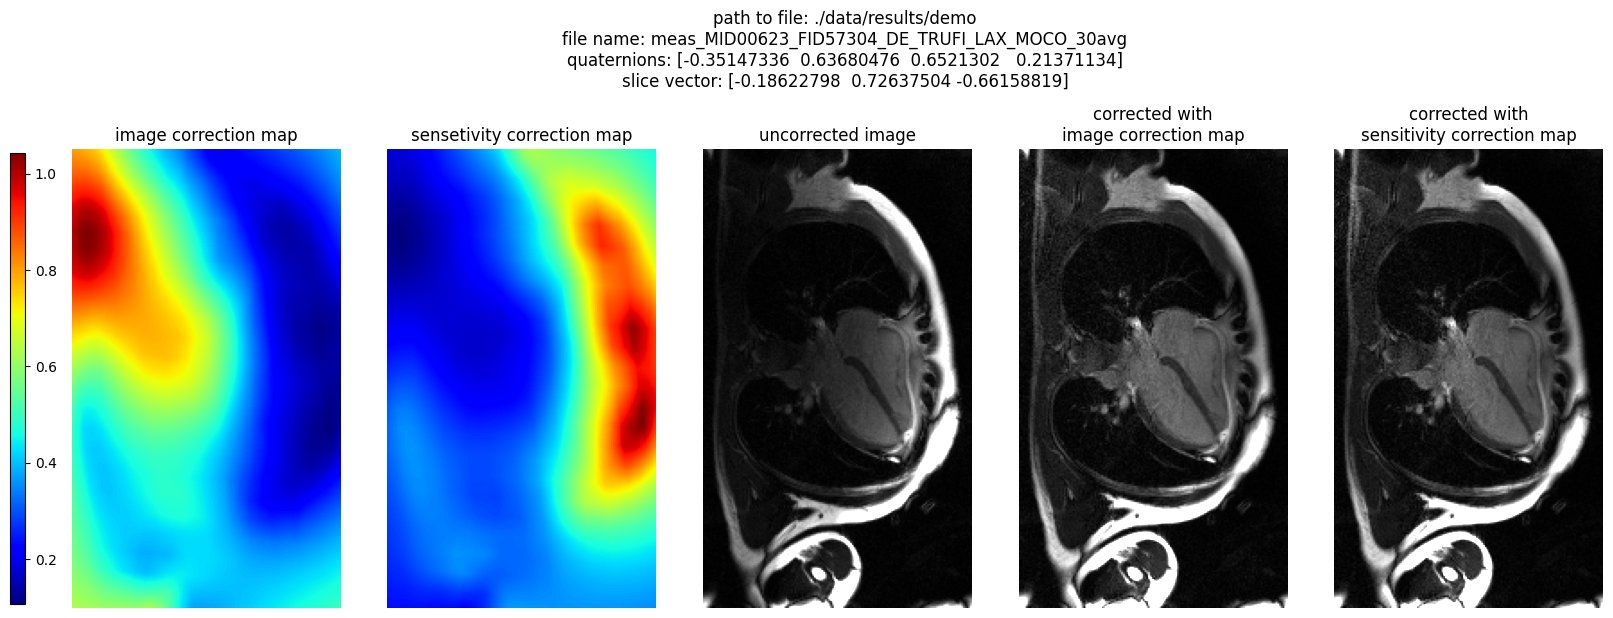

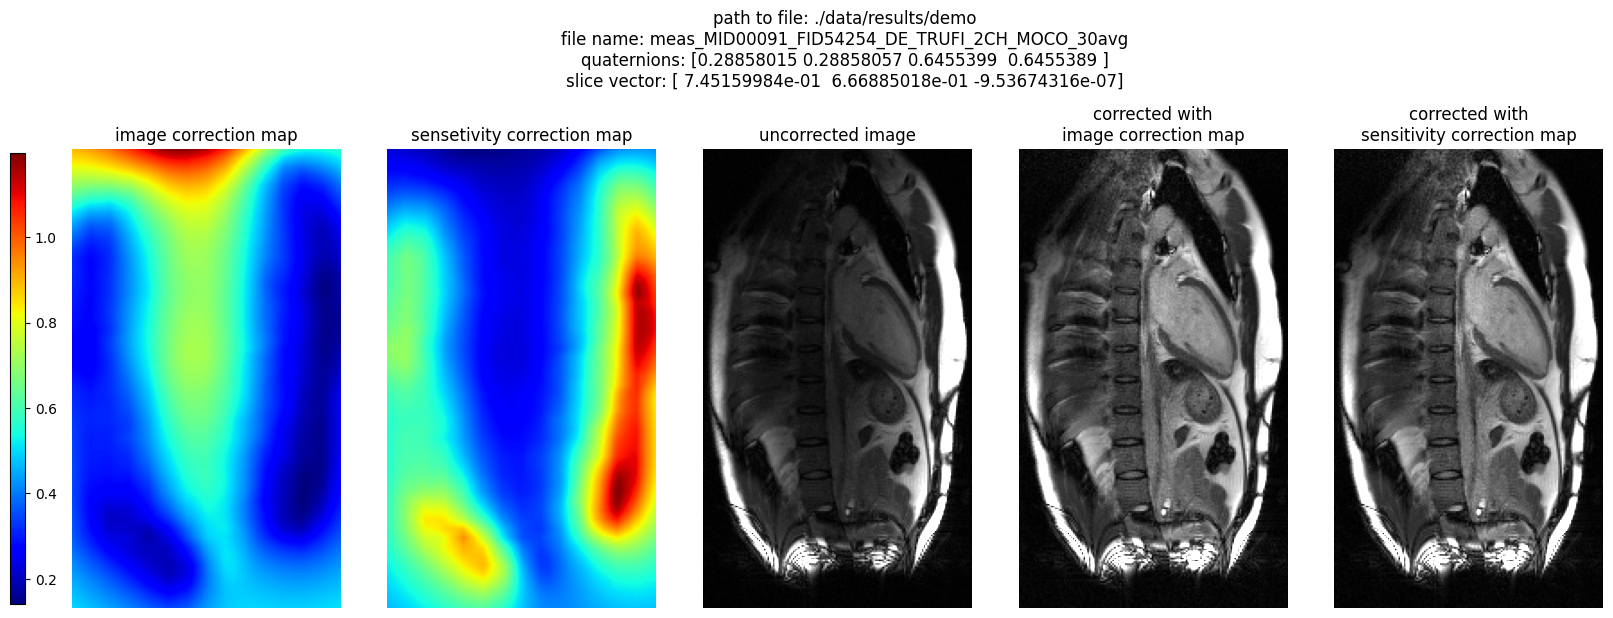

In [12]:
sli_idx = 0 # changing this number will show different slices
subfolder = ['demo'] #set this to None, if you want to go through all the subfolders inside input_folder
output_folder = "results"
displaying_results(base_dir=base_dir, input_folder=input_folder,
                   output_folder=output_folder, folder_names=subfolder, sli_idx=sli_idx,
                   fig_h=10, show_both=True) #set show_both = True to display both results